In [1]:
from multiprocessing import Pool
from functools import partial
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

from neurodsp.sim import sim_synaptic_kernel

from timescales import sim
from timescales.fit import PSD
from timescales.conversions import convert_knee

# Welch's PSD vs AR-PSD vs RNN

This notebook compares timescales estimates as knee frequency, between fitting a PSD using Welch's and AR PSD, and a recurrent neural net (RNN) configured similar to AR models. The RNN has a persistent hidden state that is learned by sliding a window across the signal and followed by a few linear layers with ReLU activations beteen. The objective of the RNN is minimizing loss of predicted knee frequency.

In [2]:
class RNN(torch.nn.Module):
    """Recurrent neural net."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        
        super(RNN, self).__init__()
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        
        # RNN
        self.rnn0 = torch.nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Linear layers with non-linear activations
        self.fc0 = torch.nn.Linear(hidden_dim, hidden_dim*2)
        self.relu0 = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(hidden_dim*2, hidden_dim//2)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim//2, output_dim)

        
    def forward(self, X):
        
        out, hn = self.rnn0(X)
        out = self.fc0(out[:, -1]) 
        out = self.relu0(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        
        return out
    
    
class RNNTrain:
    """Class to train and test a RNN."""
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.knee_freq = None
        
        
    def train(self, X, y, lr=.001, n_epochs=1000, batch_size=32):
        """Train the model."""
        
        model = RNN(self.input_dim, self.hidden_dim,
                    self.layer_dim, self.output_dim)
        
        # Optimizer & loss
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_func = torch.nn.L1Loss()
        
        n_batches = int(np.floor(X.size(0)/batch_size))
        
        for i in tqdm(range(n_epochs)):

            inds = np.arange(len(X_train)).astype(int)
            np.random.shuffle(inds)

            X = X[inds]
            y = y[inds]
            
            for j in range(n_batches):

                # Reset gradient
                optimizer.zero_grad()
                
                # Slice batch
                X_batch = X[j*batch_size:(j+1)*batch_size]
                y_batch = y[j*batch_size:(j+1)*batch_size]
                y_batch = y_batch.reshape(batch_size, -1)

                # Forward
                out = model(X_batch)

                # Loss
                loss = loss_func(out.squeeze(), y_batch.squeeze())

                # Backprop
                loss.backward()

                # Step params
                optimizer.step()

            if i % 50 == 0:
                print('Epoch: {}, Loss: {}'.format(i, loss.item()))
        
        torch.save(model.state_dict(), 'rnn_model')
        
        
    def fit(self, X):
        """Fit AR input."""
        
        model = RNN(self.input_dim, self.hidden_dim,
                    self.layer_dim, self.output_dim)
        
        model.load_state_dict(torch.load('rnn_model'))
        

        if X.ndim == 2:
            X = X.reshape(1, *X.shape)
  
        if isinstance(X, np.ndarray):
            X = torch.tensor(X.astype(np.float32))

        self.knee_freq = model(X).detach().numpy()[0][0]

In [3]:
# Functions
def sample(ys):
    """Sample spikes."""
    return ys > np.random.rand(len(ys))
 
def bin_spikes(ys, fs, bin_size):
    """Bin spikes."""
    ys, _ = sim.bin_spikes(ys, fs, bin_size, 0, 1)
    return ys

def to_ar(X, n_seconds, fs, bin_size, order):
    """Convert array to an AR problem."""
    
    n_windows = int(n_seconds * fs//bin_size) - order
    X_reshape = np.zeros((n_windows, order), dtype=np.float32)
    
    for j in range(order, len(X)):
        X_reshape[j-order] = X[j-order:j]
    
    X_reshape = X_reshape.swapaxes(0, 1)
    X_reshape = X_reshape.reshape(1, *X_reshape.shape)
    
    return X_reshape

def sim_spikes(i, n_seconds=None, fs=None, bin_size=None,
               n_iters=None, order=None, knees=None):
    """Simulate spikes in parallel."""
    
    knee = knees[i]
    tau = convert_knee(knee)
    kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)

    n_windows = int(n_seconds * fs//bin_size) - order
    X_train_reshape = np.zeros((n_windows, order))

    # Get spike probability
    np.random.seed(10000+i) 
    X_train = sim.sim_spikes_prob(n_seconds, fs, kernel)
    
    # Sample spikes
    X_train = sample(X_train)
    
    # Bin spikes
    X_train = bin_spikes(X_train, fs, bin_size)

    # Convert array to an AR problem
    for j in range(order, len(X_train)):
        X_train_reshape[j-order] = X_train[j-order:j]
        
    return X_train_reshape

## Simulation

Knees are simulated as a random normal distribution around 20 Hz, with a standard deviation of 5 Hz, in 2 second signal. The goal is for each estimation method to recover the simulated knee. The training and testing seeds are disjointed (no seeds in common).

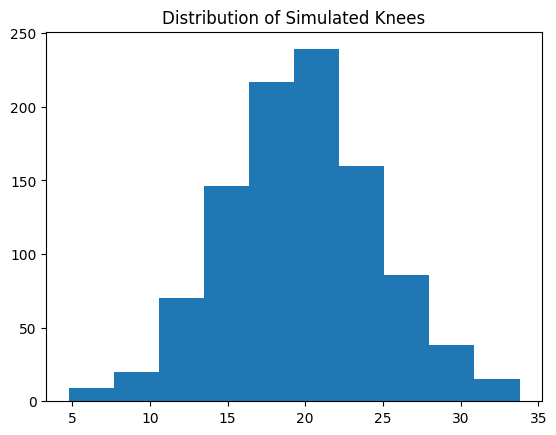

In [4]:
# Settings
n_seconds = 2
fs = 10000
bin_size = 20
order = 5

# Knees
np.random.seed(0)
plt.title('Distribution of Simulated Knees')
knees = np.random.normal(20, 5, size=1000)
plt.hist(knees);

## Train

Below, the RNN is trained on 1000 independent instances. This is slow due to a high sampling rate required for binning spiking simulations.

In [5]:
# Simulate in parallel (skip if already ran)
n_iters = 1000
inds = np.arange(n_iters)

pfunc = partial(sim_spikes, n_seconds=n_seconds, fs=fs,
                bin_size=bin_size, n_iters=n_iters, order=order, knees=knees)

with Pool(processes=6) as pool:
    mapping = pool.imap(pfunc, inds)
    results = list(tqdm(mapping, total=len(inds)))
    
# Convert to f32 tensors
X = np.array([i for i in results])
X = torch.from_numpy(X.astype(np.float32))
X = X.swapaxes(1, 2)

# Get target tensor
y = torch.from_numpy(knees.astype(np.float32).reshape(-1, 1))

# Save for faster reloading
np.save('X.npy', X.detach().numpy())
np.save('y.npy', y.detach().numpy())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
# Reload
X = torch.from_numpy(np.load('X.npy'))
y = torch.from_numpy(np.load('y.npy'))

X_train = X[:800]
y_train = y[:800]

X_test = X[800:]
y_test = y[800:]

In [7]:
# Train RNN
input_dim = X_train.size(-1)
hidden_dim = 64

rnn = RNNTrain(input_dim, hidden_dim, 1, 1)
rnn.train(X_train, y_train, lr=.01, n_epochs=1000, batch_size=32)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0, Loss: 5.351895809173584
Epoch: 50, Loss: 1.383803367614746
Epoch: 100, Loss: 1.045954942703247
Epoch: 150, Loss: 0.9461120367050171
Epoch: 200, Loss: 0.7507925033569336
Epoch: 250, Loss: 0.7461069822311401
Epoch: 300, Loss: 0.5372047424316406
Epoch: 350, Loss: 0.47606194019317627
Epoch: 400, Loss: 0.41487979888916016
Epoch: 450, Loss: 0.512054443359375
Epoch: 500, Loss: 0.3881128430366516
Epoch: 550, Loss: 0.5845201015472412
Epoch: 600, Loss: 0.3788730204105377
Epoch: 650, Loss: 0.35279807448387146
Epoch: 700, Loss: 0.5303070545196533
Epoch: 750, Loss: 0.2989896535873413
Epoch: 800, Loss: 0.5146409273147583
Epoch: 850, Loss: 0.34177279472351074
Epoch: 900, Loss: 0.4609178304672241
Epoch: 950, Loss: 0.4130074679851532


## Test

Simulate new test data and fit: 1) Welch's PSD, 2) AR-PSD and 3) RNN.

In [8]:
n_iters = len(X_test)
knees_est = np.zeros((4, n_iters))

for i in tqdm(range(n_iters), total=n_iters):
    
    x = X_test[i]
    x = torch.hstack((x[0], x[-1][-order:]))
    x = x.reshape(1, *x.shape)
    
    # Welch's
    psd_welch = PSD()
    psd_welch.compute_spectrum(x, fs//bin_size, nperseg=250)
    psd_welch.fit()

    # AR
    psd_ar = PSD()
    psd_ar.compute_spectrum(x, fs//bin_size, ar_order=order)
    psd_ar.fit()
    
    # RNN
    rnn.fit(X[i])
    
    # Results
    knees_est[0, i] = psd_welch.knee_freq
    knees_est[1, i] = psd_ar.knee_freq
    knees_est[2, i] = rnn.knee_freq
    knees_est[3, i] = knees[800:][i]

  0%|          | 0/200 [00:00<?, ?it/s]

## Results


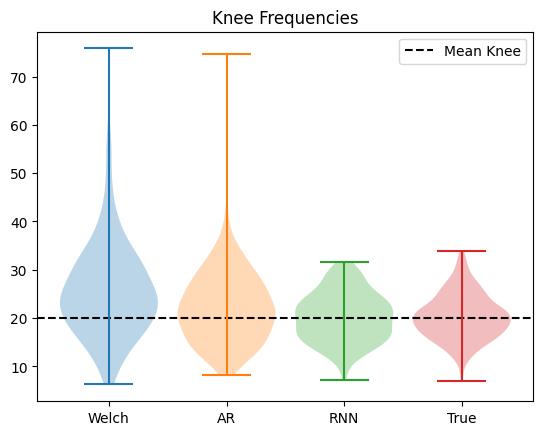

In [12]:
# Plot results
pos = [1, 1.6, 2.2, 2.8]
plt.axhline(20, ls='--', color='k', label='Mean Knee')
plt.violinplot(knees_est[0], positions=[pos[0]])
plt.violinplot(knees_est[1], positions=[pos[1]])
plt.violinplot(knees_est[2], positions=[pos[2]])
plt.violinplot(knees_est[3], positions=[pos[3]])

plt.title('Knee Frequencies')
plt.xticks(ticks=pos, labels=['Welch', 'AR', 'RNN', 'True'])
plt.legend();